## Discovering transcription factor binding motifs and binding sites in promoter sequences

As we discussed in the introduction session, transcription of DNA into RNA is carried out by the RNA polymerase, which is recruited to the DNA by transcription factors (TFs), proteins that bind specific sequence elements in the DNA. We typically describe the sequence specificity of transcription factors by position-specific weight matrices (PWMs), giving the probabilities of finding each of the four nucleotides at each position of binding sites. Let's see how we can use the HMM framework to describe promoter sequences, find binding sites and infer the PWM of a transcription factor from sequences that contain such binding sites.

### Block 1. Generating synthetic sequence data

Testing with ground truth data is crucial when we develop code. Ground truth biological data is often difficult to obtain, as even the measurement processes are complex, with hard to identify and characterize biases. That is why synthetic data is important: it allows us to determine whether our code works correctly within the assumptions of the model underlying the code. Of course, this does not mean that real data obeys these assumptions, which is why showing that the code works on synthetic data doesn't mean that we have a good tool to analyze real data. Nevertheless, the correctness of the implementation is the first step that we always need to check. So let's generate ourselves a ground truth dataset of "promoter sequences" containing binding sites for a transcription factor.

1. Generate a PWM of your liking
- typical length for eukaryotic TF binding sites is 6-8 nucleotides
- play around with the **bias** of your PWM, i.e. the sequence that has the highest probability under the PWM model
- make sure to write functions that:
    - calculate the information content of the PWM (we'll look into this in a future session)
    - *sample* a binding site from this PWM in proportion to its probability
2. Generate random promoter sequences your chosen A,C,G,T composition.
3. Introduce binding sites sampled from the PWM in the promoter sequences. Keep track of this information to be able to check it later.
4. Check if motif finding software (e.g. MEME, we'll talk about it later as well) recovers the motif you places in your sequence.

### Block 2. Predicting binding sites for TFs with known sequence specificity

1. Implement the forward/backward algorithms. Can you run them on your sequences?
2. Adapt your code to calculate instead ratios of sequence likelihoods (as described in https://cdn.aaai.org/ISMB/2000/ISMB00-007.pdf).
2. Use the functions you implemented to evaluate the posterior probability of binding sites along the promoter sequences you created.
3. Compare your results with your ground truth data.

### Block 3. Training the HMM

Now let's see if we can use the tools we got to actually infer the specificity of the TF from the synthetic data that you generated.

1. Implement the Baum-Welch algorithm to infer the PWM and the transition probability between random sequence and binding sites in promoter sequences (assuming an HMM with 4 states: Start, Random, BindingSite, End).
2. Does it inferred PWM match the one you picked the beginning?


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seqlogo
# from IPython.display import display, Markdown
from jupyprint import jupyprint, arraytex
from tabulate import tabulate
import arraytex as atx
import graphviz
from pymemesuite.common import Sequence
# from pymemesuite.fimo import FIMO

In [2]:
# Generate a random Position probability Matrix based on Dirichlet distribution
def get_random_pwm(composition_bias, tf_length):
    # This optimally should use a very heavily weighted alpha, gamma << 1
    # for each nucleotide as with balanced alpha information content is very low
    # Dirichlet is generalization of Beta distribution, codomain is [0,1]
    ppm = np.array(np.random.dirichlet(composition_bias, size=(tf_length))).T
    # change dim of composition bias to match counts
    pseudocounts = composition_bias[:, np.newaxis]
    pwm = ppm + pseudocounts
    pwm = pwm / np.sum(pwm, axis=0)
    return pwm, ppm

In [3]:
def get_random_pwm_manual (tf_length: int, 
                    num_seqs: int,
                    composition_bias: list) -> pd.DataFrame:
    """ Generate a random PWM with a given initial bias. """
    # Randomly generate potential promoter PWM with a given initial bias
    dna_letters = ['A', 'C', 'G', 'T']
    dna_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    sequences = []
    for _ in range(0, num_seqs):
        # equal probability (i.e. no bias) when using randint, otherwise use choice distribution to make ppm
        sequence = ''.join([dna_letters[np.random.choice(range(4), p=composition_bias)] for _ in range(tf_length)])
        sequences.append(sequence)
        
    print(f"Randomly generated {num_seqs} sequences of length {tf_length}\nwith composition bias {composition_bias}")

    # count the number of occurrences of each letter in each position
    counts = np.zeros((len(dna_letters), tf_length), dtype=int)
    for sequence in sequences:
        for i, letter in enumerate(sequence):
            counts[dna_dict[letter], i] += 1

    # convert counts to probabilities
    ppm_raw = counts / counts.sum(axis=0)

    # change dim of composition bias to match counts
    pseudocounts = composition_bias[:, np.newaxis]

    # add pseudocount (from composition bias) to raw_ppm before normalizing to pwm
    pwm_raw = (counts + pseudocounts) / (counts.sum(axis=0) + len(dna_letters) * pseudocounts)
    
    return pwm_raw, ppm_raw


In [4]:
dna_letters = ['A', 'C', 'G', 'T']
dna_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
tf_length = np.random.randint(6, 9)
# print(f"Generating random TF binding site of length {tf_length}")

# This is dirichelet distribution alpha, used for background composition (emission)
# Can also be used to generate a random PWM, should sum to 1 for ease of use
# composition_bias = np.array([0.1, 0.1, 0.7, 0.1]) # shuffle elements for PWM generation for each position
composition_bias = np.ones(len(dna_letters))*0.25  # For background composition

bck_comp_dict = tabulate(pd.DataFrame(zip(dna_letters, composition_bias)), showindex=False)
# bck_comp_dict = tabulate(pd.DataFrame(zip(dna_letters, composition_bias)), headers=['Letter', 'Bkg comp.'], showindex=False)
print(f"\nBackground Composition (Emission):\n{bck_comp_dict}")

# manually randomly generate few potential tf binding site with bckground composition bias
# num_seqs = 5  # keep low to avoid sequence composition approaching initial bias
# pwm_raw, ppm_raw = get_random_pwm_manual(tf_length, num_seqs, composition_bias)

# Get pwm from a ppm generated by dirichlet distribution
# NOTE purely randomly generating pwm typically gives a very low information content < 2.5
# # pwm_raw, ppm_raw = get_random_pwm(composition_bias, tf_length)

# Just manually define a pwm so that it has a higher information content
tf_length = 6
pwm_raw = np.array([[0.11, 0.2, 0.03, 0.66], # 1
                     [0.11, 0.02, 0.02, 0.85], # 2
                     [0.02, 0.11, 0.66, 0.21], # 3
                     [0.75, 0.02, 0.02, 0.21], # 4
                     [0.02, 0.94, 0.02, 0.02], # 5
                     [0.57, 0.02, 0.11, 0.3], # 6
                     #[0.75, 0.11, 0.02, 0.02], # 7
                     #[0.3, 0.1, 0.02, 0.84] # 8
                     ]).T

# Create df of pwm and ppm for nice printing
# ppm_df = pd.DataFrame(ppm_raw, index=dna_letters, columns=range(tf_length))
# print(f"\nPosition Probability Matrix:\n{ppm_df}")
pwm_df = pd.DataFrame(pwm_raw, index=dna_letters, columns=range(tf_length))
print(f"\nTF of length {tf_length} Position Weight Matrix:\n{tabulate(pwm_df, headers='keys', tablefmt='psql', showindex=True)}")

# Print most likely sequence from pwm
most_probable_tf_binding_site = ''.join([dna_letters[np.argmax(pwm_raw[:, i])] for i in range(tf_length)])
print(f"\nMost probable TF binding site sequence: {most_probable_tf_binding_site}")



Background Composition (Emission):
-  ----
A  0.25
C  0.25
G  0.25
T  0.25
-  ----

TF of length 6 Position Weight Matrix:
+----+------+------+------+------+------+------+
|    |    0 |    1 |    2 |    3 |    4 |    5 |
|----+------+------+------+------+------+------|
| A  | 0.11 | 0.11 | 0.02 | 0.75 | 0.02 | 0.57 |
| C  | 0.2  | 0.02 | 0.11 | 0.02 | 0.94 | 0.02 |
| G  | 0.03 | 0.02 | 0.66 | 0.02 | 0.02 | 0.11 |
| T  | 0.66 | 0.85 | 0.21 | 0.21 | 0.02 | 0.3  |
+----+------+------+------+------+------+------+

Most probable TF binding site sequence: TTGACA


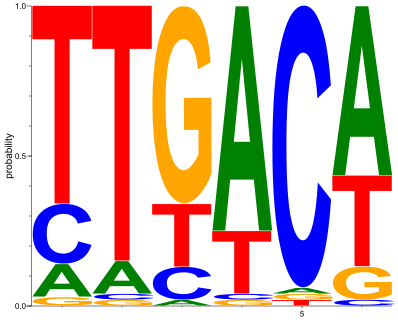

In [5]:
ppm = seqlogo.Ppm(pwm_raw)
seqlogo.seqlogo(ppm, font_size=30, ic_scale=False, format='svg') # attach to axis not working

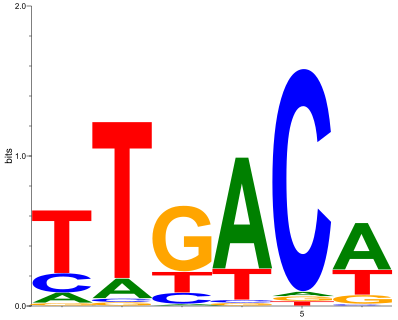

In [6]:
ppm = seqlogo.Ppm(pwm_raw)
seqlogo.seqlogo(ppm, font_size=30, ic_scale=True, format='svg') # attach to axis not working

In [7]:
# calculate information content from pwm
def get_pwm_information_content(pwm, composition_bias):
    bckg_freq = composition_bias[:, np.newaxis]
    ic = np.sum( pwm * np.log2(pwm / bckg_freq), axis=None)
    return ic

def sample_binding_site_from_pwm(pwm, num_samples):
    num_positions = pwm.shape[1]
    # store the sampled sequences
    sampled_sequences = []
    for _ in range(num_samples):
        # For each position, sample a letter based on the PWM probabilities
        sampled_sequence = ''.join(np.random.choice(dna_letters, p=pwm[:, i]) for i in range(num_positions))
        sampled_sequences.append(sampled_sequence)
    return sampled_sequences

In [8]:
# Note that randomly generating motif from Dirichlet often gives too low information content to be useful
ic = get_pwm_information_content(pwm_raw, composition_bias)
print(f"\nInformation content of the PWM: {ic:0.3f} bits")


Information content of the PWM: 5.652 bits


In [9]:
# Get most likely transcription factor sequence
most_probable_tf_binding_site = ''.join([dna_letters[np.argmax(pwm_raw[:, i])] for i in range(tf_length)])
print(f"\nMost probable TF binding site sequence: {most_probable_tf_binding_site}")


Most probable TF binding site sequence: TTGACA


In [10]:
# sample 10 binding sites and print their associated probabilities
num_samples = 1

# NOTE determine whether to randomly get TF sample or use the most probable TF binding site
# sampled_sequences = sample_binding_site_from_pwm(pwm_raw, num_samples)  # get samples
sampled_sequences = [most_probable_tf_binding_site]  # get most probable --> ensure this matches above num_samples!!

# Calculate the probabilities of the sampled sequences
sampled_probs = []
for seq in sampled_sequences:
    prob = 1.0
    for i, letter in enumerate(seq):
        prob *= pwm_raw[dna_letters.index(letter), i]
    sampled_probs.append(prob)
# Print the sampled sequences and their probabilities
print("\nSampled sequences and their probabilities:")
for seq, prob in zip(sampled_sequences, sampled_probs):
    print(f"Sequence: {seq}, Probability: {prob:.6f}")


Sampled sequences and their probabilities:
Sequence: TTGACA, Probability: 0.148789


In [11]:
def create_random_sequence_with_sampled_sites(length, composition_bias, sampled_sequences):
    # Generate a random sequence with the given length and background composition bias
    random_sequence = ''.join(np.random.choice(dna_letters, size=length, p=composition_bias))

    tf_positions = []
    
    # Randomly select positions to insert the sampled sequences
    # no validation of positions, so may overlap
    for seq in sampled_sequences:
        pos = np.random.randint(0, length - len(seq) + 1)
        tf_positions.append(pos)
        random_sequence = random_sequence[:pos] + seq + random_sequence[pos + len(seq):]
    
    return random_sequence, tf_positions

In [12]:
# Create and print random sequence with sampled sites
random_sequence, tf_positions = create_random_sequence_with_sampled_sites(200, composition_bias, sampled_sequences)

print(f"\nRandom sequence with sampled binding sites:\n{random_sequence}")
print(f"Sampled binding sites inserted at positions: {tf_positions}")


Random sequence with sampled binding sites:
CACCTATAACTAATCTTCTCTTGTTCTGACCGGAACCGCAGGCAACTTGTGTCAACCCCGTCAGTATCTACTGCTGTTATCCACATCGTCCAACCTGTCCCCAATCGTTAACTGCGGCTCCTAACATCCAGTGTTTTGCTGACGGTACTGGATCTAATTGACATTGCCATGAATGACTAGTTCCTGTCTTATACTTTAGG
Sampled binding sites inserted at positions: [157]


In [13]:
# Sanity Check Manually search string for the sampled binding sites with regex
import re
def find_binding_sites_in_sequence(sequence, binding_sites):
    found_positions = {}
    for site in binding_sites:
        positions = [m.start() for m in re.finditer(site, sequence)]
        if positions:
            found_positions[site] = positions
        else:
            raise ValueError(f"Binding site {site} not found in the sequence!!?!?!")
    return found_positions
# Find binding sites in the random sequence
found_positions = find_binding_sites_in_sequence(random_sequence, sampled_sequences)
print(f"\nSanity Check binding site in the random sequence:\n{found_positions}")



Sanity Check binding site in the random sequence:
{'TTGACA': [157]}


Check the log-likelihood of the sequence given the background composition
$L(s|\vec{x})=\sum_in_i\ \text{log}_2(\pi_i)$ just to make sure our random sequence didn't end up too biased

In [14]:
counts = np.zeros((len(dna_letters),), dtype=int)
# There's probably a nice regex to do this but this is easy
for letter in random_sequence:
    counts[dna_dict[letter]] += 1
# Convert counts to log-likelihood
EL_s = np.sum(counts * np.log2(composition_bias))
L_s = np.sum(counts * np.log2(np.array(counts, dtype="float")/len(random_sequence)))
# P_s = 1 # Sanity Check probability and to see what 2^-400 is (3e-121)
# for count in counts:
#     P_s *= np.power(0.25,count)
# print($"Expected Likelihood of sequence given background composition{P_s}")
print(f"\nLog-Likelihood of the random sequence length {sum(counts)} (independence assumption): {L_s:.2f}"+
      f" Expected: {EL_s}")


Log-Likelihood of the random sequence length 200 (independence assumption): -393.07 Expected: -400.0


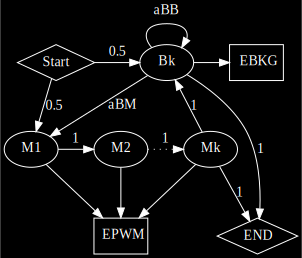

In [15]:
# Make nice visualization of HMM
dot = graphviz.Digraph(comment='HMM', format='svg')

dot.attr(rankdir='TD')
dot.attr(bgcolor='black')
dot.attr('edge', color='white',fontcolor='white')
dot.attr('node', style='filled',fillcolor='black', fontcolor='white', color='white')

# Nodes setup
dot.node('M', label='<M<SUB>1</SUB>>')
dot.node('N', label='<M<SUB>2</SUB>>')
dot.node('O', label='<M<SUB>k</SUB>>')
dot.node('S', label='Start', shape='diamond')
dot.node('B', label='<B<SUB>k</SUB>>')
dot.node('E', label='<E<SUB>PWM</SUB>>', shape="rect")
dot.node('F', label="<E<SUB>BKG</SUB>>", shape="rect")
dot.node('D', label="<END>", shape='diamond')

# Atrributes need to be applied to node individually
# as syntax for specfic assignment (as in normal graphviz)
# not working, not equivalent to dot
with dot.subgraph() as s:
    s.attr(rank='same')
    s.node('M')
    s.node('N')
    s.node('O')
    

with dot.subgraph() as s:
    s.attr(rank='source')
    s.node('S')
    s.node('B')
    s.node('F')

with dot.subgraph() as s:
    s.attr(rank='sink')
    s.node('E')
    s.node('D')

# dot.attr(rank="same;M;N;O;B")
# dot.attr(rank="sink;E;")
# dot.attr(rank="source;B;")

# Edges setup
dot.edge('S', 'M', label='0.5')
dot.edge('S', 'B', label='0.5')
dot.edge('M', 'N', label='1')
dot.edge('N', 'O', label='1', style='dotted')
dot.edges(['ME', 'NE', 'OE', 'BF']) # edges doesn't work if node name > 1 char
dot.edge('O','D', label="1")
dot.edge('B','D', label="1")
dot.edge('O', 'B', label='1')
dot.edge('B', 'B', headlabel='<a<SUB>BB</SUB>>',
          labeldistance="4.0", labelangle="55",
          headport='ne', tailport="nw",
          labelfloat="true")
dot.edge('B', 'M', label='<a<SUB>BM</SUB>>')
# dot.edge('M', 'B', label='<a<SUB>MB</SUB>>')
dot


Forward: $f_k(i)=e_k(x_i)\ \sum_lf_l(i-1)\ a_{lk}$, i.e. emission of current state * sum of possible transitions to this state * previous term

Backward: $b_k(i)=\sum_lb_l(i+1)e_l(x_{i+1})a_{kl}$, i.e. sum of all possible transitions to this state * emissions of previous states to this one * previous term

Where $k$ is the current state, $l$ is the previous state, $i$ is the position in the sequence, $x_i$ is the nucleotide at that position in the sequence, $e_k(x_i)$ is the probability of emission of nucleotide $x_i$ from state $k$, $a_{lk}$ is the probability of transition from state $l$ to state $k$.

Define a 7-state (TF length  + 1) HMM for whether (M) or not (B) we are in transcription factor (with start and end state)

We estimate the transition probabilities of Background to Match State based on the number of transcription factor binding sites we expect to find as $a_{BM}=n/L$. Since transitions between Match states for each nucleotide is 1, there is only one meaningful state transition $a_{BM}$.

In [16]:
# Transition and Emission probabilities
a_bm = num_samples/len(random_sequence)
a_bb = 1 - a_bm
# T_m = np.array([[a_bb, a_bm],[0, 1]])
# This transition matrix would need to dynamically change
# Based on the length of the TF binding site
T_m = np.array([[a_bb, a_bm, 0, 0, 0, 0, 0], # B
                [0, 0, 1, 0, 0, 0, 0], # M1 -> M2
                [0, 0, 0, 1, 0, 0, 0], # M2 -> M3
                [0, 0, 0, 0, 1, 0, 0], # M3 -> M4
                [0, 0, 0, 0, 0, 1, 0], # M4 -> M5
                [0, 0, 0, 0, 0, 0, 1], # M5 -> M6
                [1, 0, 0, 0, 0, 0, 0] # M6 -> B
                ])
E_m = np.concatenate((composition_bias.reshape(-1,1), pwm_raw), axis=1)
jupyprint(f"Transition $T={arraytex(T_m)}$")
# jupyprint(f"Match Emission $E_{{PWM}}={arraytex(pwm_raw)}$")
# jupyprint(f"Background Emission $E_{{BKG}}={arraytex(composition_bias.reshape(-1,1))}$")
jupyprint(f"Emission Matrix $E={arraytex(E_m)}$")

Transition $T=\begin{bmatrix}{} 0.995 & 0.005 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 \\ 1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ \end{bmatrix}$

Emission Matrix $E=\begin{bmatrix}{} 0.25 & 0.11 & 0.11 & 0.02 & 0.75 & 0.02 & 0.57 \\ 0.25 & 0.2 & 0.02 & 0.11 & 0.02 & 0.94 & 0.02 \\ 0.25 & 0.03 & 0.02 & 0.66 & 0.02 & 0.02 & 0.11 \\ 0.25 & 0.66 & 0.85 & 0.21 & 0.21 & 0.02 & 0.3 \\ \end{bmatrix}$

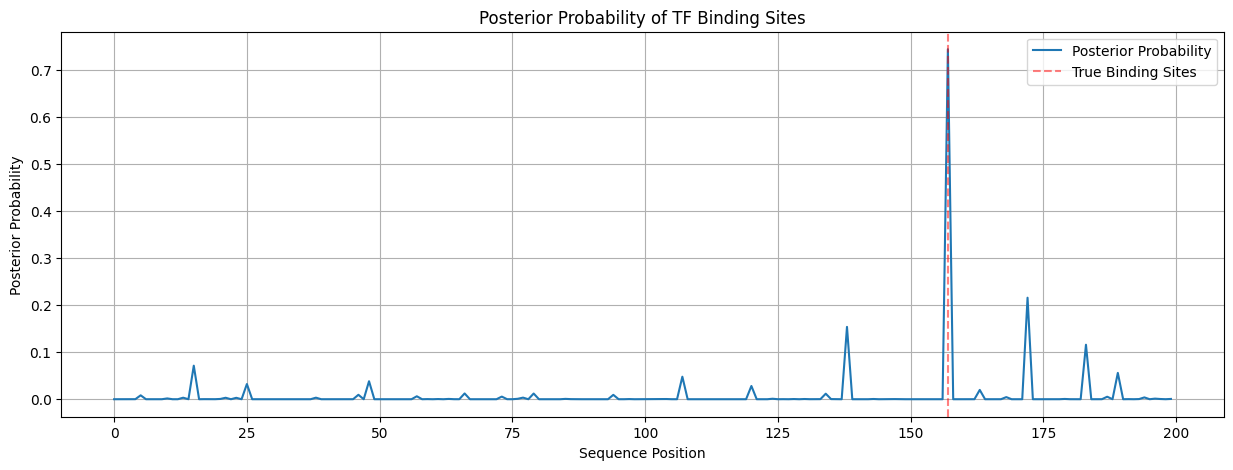

In [ ]:
def forward_backward(sequence, T_m, E_m, dna_dict):
    seq_len = len(sequence)
    num_states = T_m.shape[0]
    
    # Forward and Backward size sequence length x number of states
    forward = np.zeros((seq_len, num_states))
    backward = np.zeros((seq_len, num_states))
    
    # Start in background state, playing forward through states sequences
    forward[0, 0] = 1.0
    
    # NOTE this is not the most efficient as most transitions are 0 probability,
    # a simpler model would be to use only one match state
    # Forward
    for i in range(1, seq_len):  
        for k in range(num_states): # outer state loop
            for l in range(num_states): # inner state loop -> find transition probabilities
                forward[i, k] += forward[i-1, l] * T_m[l, k]
            forward[i, k] *= E_m[dna_dict[sequence[i]], k]
    
    # Initialize last column of backward matrix, evaluate all states
    backward[seq_len-1, :] = 1.0

    # Backward, possibility that we ended in any of the states
    for i in range(seq_len-2, -1, -1):
        for k in range(num_states):
            for l in range(num_states): # this time emissions are included in inner loop
                backward[i, k] += backward[i+1, l] * T_m[k, l] * E_m[dna_dict[sequence[i+1]], l]
    
    # NOTE calculating R likelihood ratio is potentially simple but not clear to me how to get
    # from there to the posterior probabilities

    # Calculate posterior probabilities (gamma)
    posterior = forward * backward
    posterior = posterior / np.sum(posterior, axis=1, keepdims=True) # normalize to 1 for probabilities
    # match_posterior = np.sum(posterior[:, 1:7], axis=1) # sum over match states to get full TF binding site
    match_posterior = posterior[:, 1] # match state 1 is beginning of TF binding site
    
    return match_posterior, forward, backward

# Calculate posterior probabilities
posterior_probs, forward, backward = forward_backward(random_sequence, T_m, E_m, dna_dict)

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(posterior_probs)
plt.xlabel('Sequence Position')
plt.ylabel('Posterior Probability')
plt.title('Posterior Probability of TF Binding Sites')
plt.grid(True)

# Add vertical lines for true binding sites
for pos in tf_positions:
    plt.axvline(x=pos, color='r', linestyle='--', alpha=0.5)

plt.legend(['Posterior Probability', 'True Binding Sites'])

plt.show()

In [20]:
# Print the most likely binding site
# most_likely_binding_site = np.argmax(posterior_probs)  # doesn't work for first one
most_likely_binding_site = np.argwhere(posterior_probs >= np.max(posterior_probs)*0.99).reshape(-1)
print(f"\nMost likely binding site position: {most_likely_binding_site[0]}")
# Print the most likely binding site sequence
most_likely_binding_site_seq = random_sequence[most_likely_binding_site[0]:most_likely_binding_site[0] + tf_length]
print(f"Most likely binding site sequence: {most_likely_binding_site_seq}")
# Print the real binding site location and sequence
for pos in tf_positions:
    print(f"Real binding site position: {pos}")
    print(f"Real binding site sequence: {random_sequence[pos:pos + tf_length]}")


Most likely binding site position: 157
Most likely binding site sequence: TTGACA
Real binding site position: 157
Real binding site sequence: TTGACA


For words $\alpha$ with probability to occur $\mathcal{p}_{\alpha}$, $\sum_{\alpha}\mathcal{p}_{\alpha}=1$, we maximize the likelihood of observing sequence $S$, defined with the partition function $Z$ of a sequence $$Z(S)=\sum_P\prod_{\alpha}(\mathcal{p}_{\alpha})^{N_{\alpha}(P)}$$Where $N_{\alpha}$ is the number of words, and $P$ is all possible segmentations of sequence $S$. The sum over all possible partitions of all sequences of length of $S$ $S'$ is about the same as the sum over all possible probabilities of words to the power of the number of words, $\sum_{S'}\simeq\left(\sum_{\alpha}\mathcal{p}_{alpha}\right)^{N_{av}}=1$. The average number of words can be given by $$\langle N_{\alpha}\rangle=\mathcal{p}_{\alpha}(\frac{\partial}{\partial \mathcal{p}_{\alpha}})=\frac{1}{Z}\sum_P\prod_{\alpha}N_{\alpha}(P)(\mathcal{p}_{\alpha})^{N_{\alpha}(P)}$$

With lagrange multiplier $\lambda$, the requirement $Z(S)-\lambda(\sum_{\alpha}\mathcal{p}_{\alpha}-1)$ is stationary w.r.t. $\lambda$ and $\mathcal{p}_{\alpha}$ for all $\alpha$, and $\mathcal{p}_{\alpha}=\frac{\langle N_{\alpha}\rangle}{\sum_{\beta}\langle N_{\beta}\langle}\equiv \mathcal{f}_{\alpha}$

With vector $p=(\mathcal{p}_{\alpha}|\alpha \in D)$, finding the vector $p$ that maximizes $Z$ is the same as finding the fixed point $p*$ of the nonlinear mapping $f(p)$ such that $f(p^*)=p^*$?? Some stuff describing convergence we skip a bit How do we find this convergence? We iteratively find it as $f(p)+\frac{\partial f}{\partial p}\bigg\rvert _p(p^*-p)=p^*$

We can define $\frac{\partial f}{\partial p}$ in terms of Free Energy $F=-\text{log}Z$ and the relation to the average number of words $$\langle N_{\alpha}\rangle =-\mathcal{p}_{\alpha}(\frac{\partial}{\partial \mathcal{p_{\alpha}}})F $$. How solve for $F$? We define partition sum recursive relation $$Z(1,i)=\sum_{\mathcal{l}=1}^{\mathcal{l}_{\text{max}}}\mathcal{p}_{\sigma(i,\mathcal{l})}Z(1,i-\mathcal{l})$$, where $\sigma_{i,l}$ is the substring of length $l$ that ends at $i$ in $S$, and when $\alpha(i,l)\notin D$, $\mathcal{p}_{\alpha(i,l)}=0$.

We now define (forward) likelihood ratio $$R(i)=\frac{Z(1,i)}{Z(1, i-1)}=\mathcal{p}_{\alpha(i,1)}+\frac{\sum_{l=2}^{l=\text{max}}\mathcal{p}_{\alpha(i,l)}}{\prod_{k=i-l+1}^{i-1}R(k)}$$ and backward likelihood ratio $$R'(i)=\frac{Z(i,L)}{Z(i+1,L)}=\mathcal{p}_{\alpha(i+l-1,l)}+\frac{\sum_{l=2}^{l=\text{max}}\mathcal{p}_{\alpha(i+l-1,l)}}{\prod_{k=i+1}^{i+l-1}R'(k)}$$

Unlike the forward/backward probabilities, all $R(i)$ terms are of the same order.

Baum-Welch algorithm for reinferring the transition and emission matrices. This starts by computing the $\gamma$ the (non-normalized posterior), which at each nucleotide in the sequence $x_i$ is the probability of observing that nucleotide given the state of the nucleotide given the model: $\gamma_i(t)=P(s(i)=x_i|O,\theta)$, where O is the emission of this nucleotide and $\theta$ is the HMM. Then we recompute the transition probabilities for all state transition pairs in the sequence $(x_i, x_{i+1})$ as $$\xi_{kl}(i)$$

Calculate (forward * backward) transition probabilities $\gamma(x_i)$

T_new = 

In [ ]:
def baum_welch(sequence, T_m, E_m, dna_dict, max_iter=100, eps=1e-6):
    n_states = T_m.shape[0]
    seq_len = len(sequence)
    old_log_prob = float('-inf') # start at -inf to ensure convergence
    
    for _ in range(max_iter):
        # Forward-Backward
        forward = np.zeros((seq_len, n_states))
        backward = np.zeros((seq_len, n_states))
        
        # Forward pass
        forward[0, 0] = 1.0
        for t in range(1, seq_len):
            for j in range(n_states):
                # Emission prob of each state is being multiplied like the backward pass
                # but this is not correct, should be emission prob of the current state
                forward[t, j] = sum(forward[t-1, i] * T_m[i, j] * E_m[dna_dict[sequence[t]], j] 
                                  for i in range(n_states))
                
        # Backward pass
        backward[seq_len-1] = 1.0
        for t in range(seq_len-2, -1, -1):
            for i in range(n_states):
                backward[t, i] = sum(backward[t+1, j] * T_m[i, j] * E_m[dna_dict[sequence[t+1]], j]
                                   for j in range(n_states))
        
        # Compute gamma (posterior probabilities)
        gamma = forward * backward  # Should in theory be normalized
        gamma = gamma / gamma.sum(axis=1, keepdims=True)
        
        # Compute xi (transition probabilities)
        xi = np.zeros((seq_len-1, n_states, n_states))
        for t in range(seq_len-1):
            denominator = 0
            for i in range(n_states):
                for j in range(n_states):
                    xi[t, i, j] = forward[t, i] * T_m[i, j] * E_m[dna_dict[sequence[t+1]], j] * backward[t+1, j]
                    denominator += xi[t, i, j]
            xi[t] /= denominator
        
        # Update transition matrix
        new_T = np.zeros_like(T_m)
        for i in range(n_states):
            for j in range(n_states):
                numerator = xi[:, i, j].sum()
                denominator = gamma[:-1, i].sum()
                new_T[i, j] = numerator / denominator if denominator > 0 else T_m[i, j]
        
        # Update emission matrix
        new_E = np.zeros_like(E_m)
        for k in range(E_m.shape[0]):  # For each nucleotide
            for j in range(n_states):
                numerator = sum(gamma[t, j] for t in range(seq_len) if dna_dict[sequence[t]] == k)
                denominator = gamma[:, j].sum()
                new_E[k, j] = numerator / denominator if denominator > 0 else E_m[k, j]
        
        # Check convergence
        log_prob = np.log(forward[-1].sum())
        # no update if we did not change the transition or emission matrix
        if abs(log_prob - old_log_prob) < eps:
            break
        old_log_prob = log_prob
        T_m = new_T
        E_m = new_E
        
    return E_m, T_m

# Run Baum-Welch algorithm
new_E_m, new_T_m = baum_welch(random_sequence, T_m, E_m, dna_dict)

In [ ]:
jupyprint(f"Original Emission Matrix $E={arraytex(E_m)}$")
jupyprint(f"Inferred Emission Matrix $E={arraytex(new_E_m)}$")
jupyprint(f"Original Transition Matrix $T={arraytex(T_m)}$")
jupyprint(f"Inferred Transition Matrix $T={arraytex(new_T_m)}$")

Original Emission Matrix $E=\begin{bmatrix}{} 0.25 & 0.11 & 0.11 & 0.02 & 0.75 & 0.02 & 0.57 \\ 0.25 & 0.2 & 0.02 & 0.11 & 0.02 & 0.94 & 0.02 \\ 0.25 & 0.03 & 0.02 & 0.66 & 0.02 & 0.02 & 0.11 \\ 0.25 & 0.66 & 0.85 & 0.21 & 0.21 & 0.02 & 0.3 \\ \end{bmatrix}$

Inferred Emission Matrix $E=\begin{bmatrix}{} 0.22533653799658304 & 2.3392736826000886e-134 & 5.014151047945648e-150 & 2.228638455032033e-97 & 0.3321662312736055 & 5.128755379595572e-66 & 1.0000000000000002 \\ 0.19782997476258538 & 1.9724716856417746e-83 & 6.835510711219758e-14 & 2.0780979771065173e-50 & 0.6678337687263945 & 0.6760812186874763 & 8.118647493770472e-56 \\ 0.26872508384703686 & 6.655032366276638e-13 & 3.019895842620447e-99 & 1.0000000000000002 & 8.983394831406826e-41 & 5.810540975730151e-146 & 2.904530893759356e-73 \\ 0.30810840339379475 & 0.9999999999993346 & 0.9999999999999317 & 2.778832919806966e-48 & 1.030960933508704e-86 & 0.3239187813125238 & 2.976403332678238e-129 \\ \end{bmatrix}$

Original Transition Matrix $T=\begin{bmatrix}{} 0.995 & 0.005 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 \\ 1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ \end{bmatrix}$

Inferred Transition Matrix $T=\begin{bmatrix}{} 0.9841923350239687 & 0.015807664976031283 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 \\ 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 \\ 1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\ \end{bmatrix}$